In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import yaml

In [ ]:
# This import was added to give an option to run this on Klone and laptop by toggling different file paths depending on the OS 
from sys import platform

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [ ]:
if platform == 'linux':
    NO3NO2_xlxs='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets/NO3NO2_load_timeseries.xlsx'
    NH4_xlxs='/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets/NH4_load_timeseries.xlsx'
    out_dir = "/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/nutrient_loading"
else:
    NO3NO2_xlxs='/Users/rmueller/Projects/PugetSound_NutrientSourceReduction/OneDrive - UW/Documents/Nutrient Science/9. Modeling/9.Preprocessing_SSMC/3.point_nonpoint_info_scenarios/NO3NO2_load_timeseries.xlsx'
    NH4_xlxs='/Users/rmueller/Projects/PugetSound_NutrientSourceReduction/OneDrive - UW/Documents/Nutrient Science/9. Modeling/9.Preprocessing_SSMC/3.point_nonpoint_info_scenarios/NH4_load_timeseries.xlsx'
    out_dir = "/Users/rmueller/Projects/PugetSound_NutrientSourceReduction/graphics/nutrient_loading"

# tabs are organized by run, e.g. "ssm_pnt_wq_2a"
# columns are organized by name of river or WWTP

In [ ]:
# The following WWTP names are from the "Table NLoading1" tab of 
# https://uwnetid.sharepoint.com/:x:/r/sites/og_uwt_psi/_layouts/15/Doc.aspx?sourcedoc=%7B3788B09C-126F-40BF-86AF-22DEC185E831%7D&file=SOG_NB_Figures%26Tables.xlsx&action=default&mobileredirect=true

# The two spaces in front of names reflects formatting of column names in 
# excel spreadsheet
WWTP_names = [
  "  Brightwater",
  "  South King",
  "  West Point"
]

# Some rivers discharge into more than one node and have nutrient
# loading in two columns (namely: Nooksack and Samish Bell).
# Nutrient loading for these rivers is the sum of the columns
river_names = [
   "  Green R_1",
   "  Green R_2"
]

In [ ]:
case = "main"
# load setup information
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# rename existing and reference tags to match Su Kyong's labels
ssm['run_information']['run_tag'][case]['wqm_baseline'] = "exist"
ssm['run_information']['run_tag'][case]['wqm_reference'] = "ref"

In [ ]:
run_tag_all =[ssm['run_information']['run_tag'][case][run_name] for run_name in [*ssm['run_information']['run_tag'][case]]]
run_tag_wwtp =[ssm['run_information'][f'{case.capitalize()}_WWTPs'][run_name] for run_name in [*ssm['run_information'][f'{case.capitalize()}_WWTPs']]]
run_tag_rivers =[ssm['run_information'][f'{case.capitalize()}_rivers'][run_name] for run_name in [*ssm['run_information'][f'{case.capitalize()}_rivers']]]
print("All runs: ", run_tag_all)
print("WWTP runs: ", run_tag_wwtp)
print("River runs: ", run_tag_rivers)

In [ ]:
run_description_all =[run_name for run_name in [*ssm['run_information']['run_tag'][case]]]
run_description_wwtp =[run_name for run_name in [*ssm['run_information'][f'{case.capitalize()}_WWTPs']]]
run_description_rivers =[run_name for run_name in [*ssm['run_information'][f'{case.capitalize()}_rivers']]]

## Plot up WWTP nutrient loading

In [ ]:
wwtp_df={}
wwtp_df_annual={}
wwtpNH4_df={}
wwtpNO3NO2_df={}
for idx,run_tag in enumerate(['exist','ref']):
    # read in data
    # spreadsheets in workbook organized by names in format of, e.g., "ssm_pnt_wq_exist"
    # I use the run tags to select the desired spreadsheet
    wwtpNO3NO2_df[run_tag] = pd.read_excel(
        NO3NO2_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=WWTP_names
    )
    wwtpNH4_df[run_tag] = pd.read_excel(
        NH4_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=WWTP_names
    )
    wwtp_df[run_tag]=wwtpNO3NO2_df[run_tag]+wwtpNH4_df[run_tag]
    wwtp_df_annual[run_tag] = {}
    for idx,wwtp in enumerate([*wwtp_df[run_tag]]): 
         wwtp_df_annual[run_tag][wwtp]=wwtp_df[run_tag].sum().to_list()[idx]
    wwtp_df_annual[run_tag]=pd.DataFrame(wwtp_df_annual[run_tag], index = ['total annual load'])

In [12]:
wwtp_df_annual['ref'].max()

  Coupeville                    30.114991
  Everett Snohomish           1172.538426
  La Conner                     51.011552
  Lake Stevens 002             444.971489
  Langley                       11.302989
  Marysville                   279.524995
  Mt Vernon                    715.658743
  Mukilteo                     199.281460
  Oak Harbor Lagoon            284.875962
  OF100                       1748.919773
  Penn Cove                      5.686540
  Skagit County 2 Big Lake      25.676656
  Snohomish                    264.886986
  Stanwood                      98.500113
  Swinomish                     31.734318
  Tulalip                       38.986415
  Warm Beach Campground          3.313813
dtype: float64

## plot existing and reference conditions

In [ ]:
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=14)
mpl.rc('axes', labelsize=12)
mpl.rc('axes', fontsize=12)
mpl.rc('figure', titlesize=14)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

In [13]:
# create a pretty x-axis. 
run_tag='exist'

# Load (un-named) time column 'Unnamed: 0'
df=pd.read_excel(
    NO3NO2_xlxs,
    sheet_name=f'ssm_pnt_wq_{run_tag}',
    usecols=[0]
)
time = df['Unnamed: 0']
ticks = [time[time==f'2014-{str(MM).zfill(2)}-15 00:00:00'].item() for MM in np.arange(1,13)]
ticklabels=[str(MM).zfill(2) for MM in np.arange(1,13)]

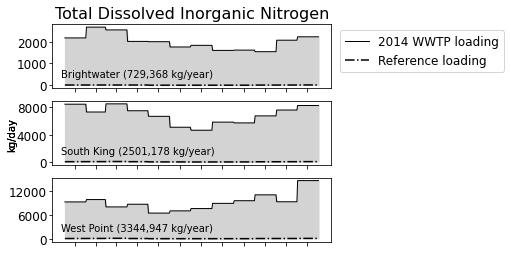

In [16]:
fig, axs = plt.subplots(3, 1,figsize = (5,2*2))
for idx,wwtp in enumerate(WWTP_names[0:3]):
    existing = wwtp_df['exist'][wwtp][0:-1]
    reference = wwtp_df['ref'][wwtp][0:-1]
    x=np.arange(len(existing))
    # plot 2014 conditions
    axs[idx].plot(time[:-1],existing,
        color = ssm['bw_line']['color']['baseline'],
        lw=ssm['bw_line']['width']['baseline'],
        ls=ssm['bw_line']['style']['baseline'],
        label='2014 WWTP loading'
    )
    # plot reference conditions
    axs[idx].plot(time[:-1], reference,
        color = ssm['bw_line']['color']['reference'],
        lw=ssm['bw_line']['width']['reference'],
        ls=ssm['bw_line']['style']['reference'],
        label='Reference loading'
    )
    # shade in region between existing and reference
    axs[idx].fill_between(time[:-1], existing, reference, color='lightgrey')
    axs[idx].yaxis.set_major_locator(MaxNLocator(3)) 
    axs[idx].xaxis.set_major_locator(MaxNLocator(14)) 
    fig.text(0.0, 0.5, 'kg/day', va='center', rotation='vertical')
    #axs[idx].set_ylabel('kg/day')
    if idx==2:
        axs[idx].set_xlabel('Months in 2014')
        axs[idx].set_xticks(ticks)
        axs[idx].set_xticklabels(ticklabels)
    else:
        axs[idx].set_xticks(ticks)
        axs[idx].set_xticklabels('')
    if idx==0:
        axs[idx].set_title('Total Dissolved Inorganic Nitrogen')
        axs[idx].legend(loc=2,bbox_to_anchor=(1.01, 1.0))
    label_string = f"{wwtp_df_annual['exist'][wwtp].item()/1000:0.3f}"
    label_string=label_string.replace(".",",")
    anchored_text = AnchoredText(
        f"{wwtp[2:]} ({label_string} kg/year)", 
        loc='lower left',
        frameon=False,
        prop=dict(fontweight="normal",color="black")
    )
    axs[idx].add_artist(anchored_text)   
plt.savefig(
    f'{out_dir}/{case}_WWTP_loadings_a.png', 
    dpi=300,
    bbox_inches='tight'
)
# plt.show()

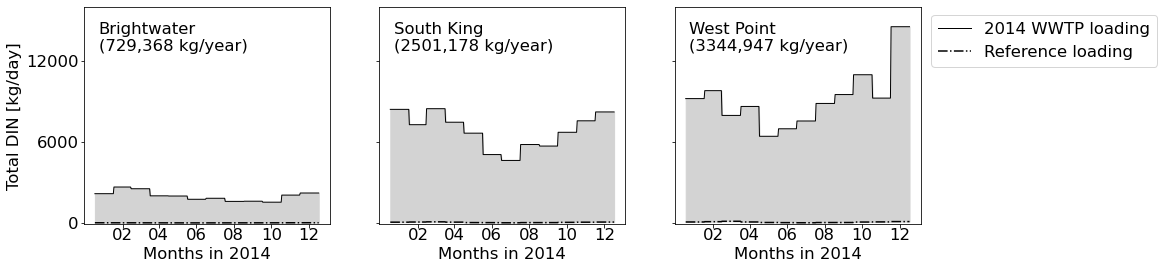

In [40]:
ticks = [time[time==f'2014-{str(MM).zfill(2)}-15 00:00:00'].item() for MM in np.arange(2,14,2)]
ticklabels=[str(MM).zfill(2) for MM in np.arange(2,14,2)]

fig, axs = plt.subplots(1, 3,figsize = (5*3,4))
for idx,wwtp in enumerate(WWTP_names[0:3]):
    existing = wwtp_df['exist'][wwtp][0:-1]
    reference = wwtp_df['ref'][wwtp][0:-1]
    x=np.arange(len(existing))
    # plot 2014 conditions
    axs[idx].plot(time[:-1],existing,
        color = ssm['bw_line']['color']['baseline'],
        lw=ssm['bw_line']['width']['baseline'],
        ls=ssm['bw_line']['style']['baseline'],
        label='2014 WWTP loading'
    )
    # plot reference conditions
    axs[idx].plot(time[:-1], reference,
        color = ssm['bw_line']['color']['reference'],
        lw=ssm['bw_line']['width']['reference'],
        ls=ssm['bw_line']['style']['reference'],
        label='Reference loading'
    )
    # shade in region between existing and reference
    axs[idx].fill_between(time[:-1], existing, reference, color='lightgrey')
    axs[idx].yaxis.set_major_locator(MaxNLocator(3)) 
    axs[idx].xaxis.set_major_locator(MaxNLocator(14)) 
    #fig.text(0.04, 0.5, 'kg/day', va='center', rotation='vertical')
    #axs[idx].set_ylabel('kg/day')
    axs[idx].set_ylim(-100,16000)
    
    axs[idx].set_xlabel('Months in 2014')
    axs[idx].set_xticks(ticks)
    axs[idx].set_xticklabels(ticklabels)
    if idx!=0:
        axs[idx].set_yticklabels("")
    if idx==2:
        axs[idx].legend(loc=2,bbox_to_anchor=(1.01, 1.0))
    label_string = f"{wwtp_df_annual['exist'][wwtp].item()/1000:0.3f}"
    label_string=label_string.replace(".",",")
    anchored_text = AnchoredText(
        f"{wwtp[2:]}\n({label_string} kg/year)", 
        loc='upper left',
        frameon=False,
        prop=dict(fontweight="normal",color="black")
    )
    axs[idx].add_artist(anchored_text)  
    axs[0].set_ylabel('Total DIN [kg/day]')
plt.savefig(
    f'{out_dir}/{case}_WWTP_loadings.png', 
    dpi=300,
    bbox_inches='tight'
)
# plt.show()

## Plot up river loadings

In [41]:
river_df={}
river_df_annual={}
riverNH4_df={}
riverNO3NO2_df={}
for idx,run_tag in enumerate(['exist','ref']):
    # read in data
    # spreadsheets in workbook organized by names in format of, e.g., "ssm_pnt_wq_exist"
    # I use the run tags to select the desired spreadsheet
    riverNO3NO2_df[run_tag] = pd.read_excel(
        NO3NO2_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=river_names
    )
    riverNH4_df[run_tag] = pd.read_excel(
        NH4_xlxs,
        sheet_name=f'ssm_pnt_wq_{run_tag}',
        usecols=river_names
    )
    # combine all nitrogen loading
    river_df[run_tag]=riverNO3NO2_df[run_tag]+riverNH4_df[run_tag]
    # combine Skagit, Snohomish, and Stillaguamish
    river_df[run_tag]["  Green"]=river_df[run_tag]["  Green R_1"] + river_df[run_tag]["  Green R_2"]
    river_df[run_tag] = river_df[run_tag].drop("  Green R_1", axis=1)
    river_df[run_tag] = river_df[run_tag].drop("  Green R_2", axis=1)
    
    river_df_annual[run_tag]={}
    for idx,river in enumerate([*river_df[run_tag]]): 
        river_df_annual[run_tag][river]=river_df[run_tag].sum().to_list()[idx]
    river_df_annual[run_tag]=pd.DataFrame(river_df_annual[run_tag], index = ['total annual load'])
    
    # # The column names have spaces in front of the names.  
    # river_df[run_tag].plot()
    # plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0))
    # plt.title(f"Nutrient loadings for {run_tag}")
    # plt.savefig(
    #     f'{out_dir}/ssm_pnt_wq_{run_tag}_rivers.png', 
    #     dpi=300,
    #     bbox_inches='tight'
    # )

In [42]:
import datetime as dt
xticks = [dt.date(2014,month,1) for month in range(1,13)]
#xticklabels = ('Jan','','Mar','','May','','Jul','','Sep','','Nov','')
xticklabels = ('01','','03','','05','','07','','09','','11','')
xtickrotation=0

  Green


/tmp/ipykernel_28766/430953892.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{out_dir}/{case}_river_loadings.pdf',
/tmp/ipykernel_28766/430953892.py:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f'{out_dir}/{case}_river_loadings.pdf',


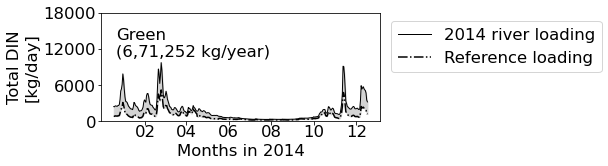

In [50]:
nrivers=1
fig, axs = plt.subplots(nrivers, 1,figsize = (5,2*nrivers))
for idx,river in enumerate(["  Green"]):
    print(river)
    existing = river_df['exist'][river][0:-1]
    reference = river_df['ref'][river][0:-1]
    x=np.arange(len(existing))
    # plot 2014 conditions
    axs.plot(time[:-1],existing,
        color = ssm['bw_line']['color']['baseline'],
        lw=ssm['bw_line']['width']['baseline'],
        ls=ssm['bw_line']['style']['baseline'],
        label='2014 river loading'
    )
    # plot reference conditions
    axs.plot(time[:-1], reference,
        color = ssm['bw_line']['color']['reference'],
        lw=ssm['bw_line']['width']['reference'],
        ls=ssm['bw_line']['style']['reference'],
        label='Reference loading'
    )
    # shade in region between existing and reference
    axs.fill_between(time[:-1], existing, reference, color='lightgrey')
    axs.yaxis.set_major_locator(MaxNLocator(3)) 
    axs.xaxis.set_major_locator(MaxNLocator(14)) 
    axs.set_xlabel('Months in 2014')
    axs.set_xticks(ticks)
    axs.set_xticklabels(ticklabels)

        
    axs.set_ylim(0,18000)
    axs.legend(loc=2, bbox_to_anchor=(1.01, 1.0))
    
    # I need to do a little song and dance in order to format number like xxx,xxx using f-string
    label_string = f"{river_df_annual['exist'][river].item()/1000:0.3f}"
    label_string=label_string.replace(".",",")
    if river != "  Whidbey east":
        label_string=label_string[0]+"," + label_string[1:]
    anchored_text = AnchoredText(
        f"{river[2:]}\n({label_string} kg/year)", 
        loc='upper left',
        frameon=False,
        prop=dict(fontweight="normal",color="black")
    )
    axs.add_artist(anchored_text) 
    axs.set_ylabel('Total DIN\n[kg/day]')
    
plt.savefig(
    f'{out_dir}/{case}_river_loadings.png', 
    dpi=1000,
    bbox_inches='tight'
)
plt.savefig(f'{out_dir}/{case}_river_loadings.pdf', 
    dpi=1000, 
    facecolor='w',                                                
    edgecolor='w',
    orientation='portrait', 
    papertype='letter',                                  
    format='pdf',                                
    transparent=False,     
    bbox_inches="tight",                
    pad_inches=0.1,                         
    frameon=None,               
    metadata=None)
#plt.show()

In [51]:
out_dir


'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/main/nutrient_loading'